In [1]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START,END
from langgraph.graph.message import add_messages

In [2]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

graph_builder=StateGraph(State)


In [3]:
graph_builder

In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm=ChatGroq(model="llama-3.1-8b-instant")

In [6]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000025291AFFC40>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000025291BD03D0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
def chatbot(state:State):
    return{"messages":[llm.invoke(state["messages"])]}

In [8]:
graph_builder=StateGraph(State)

## Adding node
graph_builder.add_node("llmchatbot",chatbot)
## Adding Edges
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)

## compile the graph
graph=graph_builder.compile()

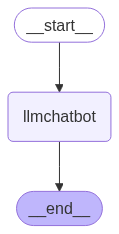

In [9]:
## Visualize the graph
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [10]:
response=graph.invoke({"messages":"Hi, How are you"})

In [11]:
response["messages"][-1].content

"I'm doing well, thank you for asking. I'm a large language model, so I don't have emotions or feelings like humans do, but I'm functioning properly and ready to assist you with any questions or topics you'd like to discuss. How can I help you today?"

In [12]:
for event in graph.stream({"messages":"Hi How are you?"}):
    for value in event.values():
        print(value["messages"][-1].content)

I'm doing well, thank you for asking. I'm a large language model, so I don't have feelings or emotions like humans do, but I'm always happy to chat with you and help with any questions or topics you'd like to discuss. How can I assist you today?


In [13]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)
tool.invoke("What is langgraph")

{'query': 'What is langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'What is LangGraph? - IBM',
   'url': 'https://www.ibm.com/think/topics/langgraph',
   'content': 'LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allowing full transparency of the agent’s state. By combining these technologies with a set of APIs and tools, LangGraph provides users with a versatile platform for developing AI solutions and workflows including chatbots, state graphs and other agent-based systems. Nodes: In LangGraph, nodes represent individual components or agents within an AI workflow. LangGraph uses enhanced decision-making by modeling c

In [14]:
## Custom function
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b

In [15]:
tools=[tool,multiply]

In [16]:
llm_with_tool=llm.bind_tools(tools)

In [17]:
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000025291AFFC40>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000025291BD03D0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A

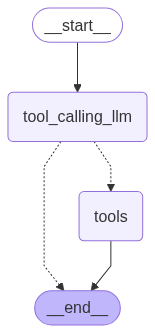

In [18]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
response=graph.invoke({"messages":"What is the recent ai news"})

In [20]:
response['messages'][-1].content

'{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.newsweek.com/nw-ai/ai-impact-awards-2025-science-engineering-2084754", "title": "AI Impact Awards 2025: The Changing Human Role in Science and Engineering - Newsweek", "score": 0.7251239, "published_date": "Wed, 25 Jun 2025 10:02:01 GMT", "content": "Newsweek _\\\\_will continue the conversation on meaningful AI innovations at our AI Impact Summit from June 23 to 25 in Sonoma, California. Click here to follow along on the live blog.\\\\__\\n\\nRequest Reprint & LicensingSubmit CorrectionView Editorial Guidelines\\n\\nSHARE:xfacebooklinkedinredditemailwhatsappCopy & Share\\n\\n✓ Link copied to clipboard!\\n\\nThe Latest in AI\\n----------------\\n\\nNEWSWEEK.AI\\n\\n06.09.25\\n\\n### Generative AI\'s Mission to Explore Strange New Worlds [...] ### AI Will Connect Mercedes-Benz Places Residents to the World\\n\\nThe new Miami condo complex will have state-of-the-art te

In [21]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (7djwhwq19)
 Call ID: 7djwhwq19
  Args:
    query: recent AI news
    search_depth: advanced
    time_range: week
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.newsweek.com/nw-ai/ai-impact-awards-2025-science-engineering-2084754", "title": "AI Impact Awards 2025: The Changing Human Role in Science and Engineering - Newsweek", "score": 0.7251239, "published_date": "Wed, 25 Jun 2025 10:02:01 GMT", "content": "Newsweek _\\_will continue the conversation on meaningful AI innovations at our AI Impact Summit from June 23 to 25 in Sonoma, California. Click here to follow along on the live b

In [22]:
response=graph.invoke({"messages":"What is 5 multiplied by 2"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 5 multiplied by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (d7cxqrhhq)
 Call ID: d7cxqrhhq
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: multiply

10


In [24]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (54e6h1103)
 Call ID: 54e6h1103
  Args:
    query: recent AI news
    search_depth: advanced
    time_range: day
    topic: news
  multiply (her6j7z3v)
 Call ID: her6j7z3v
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.csoonline.com/article/4015077/ai-supply-chain-threats-are-looming-as-security-practices-lag.html", "title": "AI supply chain threats loom — as security practices lag - csoonline.com", "score": 0.74807674, "published_date": "Tue, 01 Jul 2025 07:32:28 GMT", "content": "news ### Critical flaw in AI agent dev tool Langflow under active e